PM-ViT - AffectNet

Imports

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim

import timm
from tqdm import tqdm
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Computer Vision Project/dataset/affectnet_subset/archive"

labels.csv  Test  Train


Define transforms & RAF-DB loaders

In [ ]:
train_root = "/content/drive/MyDrive/Computer Vision Project/dataset/affectnet_subset/archive/Train"
test_root  = "/content/drive/MyDrive/Computer Vision Project/dataset/affectnet_subset/archive/Test"

# ImageNet-normalized transforms for ViT
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load full train set (we'll split into train/val)
full_train_dataset = datasets.ImageFolder(root=train_root, transform=train_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)
print("Total train images:", len(full_train_dataset))

# 80% train, 20% val
N = len(full_train_dataset)
val_size  = int(0.2 * N)
train_size = N - val_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# val uses eval transform
val_dataset.dataset.transform = eval_transform

# Test set
test_dataset = datasets.ImageFolder(root=test_root, transform=eval_transform)
print("Total test images:", len(test_dataset))

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total train images: 16108
Total test images: 14518


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


PM - ViT Model (ViT Backbone + Patch Merger)

In [ ]:
class PatchMerger(nn.Module):
    """
    Patch Merger:
    - Takes ViT token embeddings (B, N, D)
    - Applies Multi-Head Attention
    - Mean-pools tokens
    - Linear + ReLU
    """
    def __init__(self, dim=768, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.proj = nn.Linear(dim, dim)
        self.act  = nn.ReLU()

    def forward(self, x):
        # x: (B, N, D)
        attn_out, _ = self.attn(x, x, x)  # (B, N, D)
        pooled = attn_out.mean(dim=1)     # (B, D)
        out = self.proj(pooled)           # (B, D)
        out = self.act(out)
        return out


class PMViT(nn.Module):
    """
    PM-ViT:
    - Backbone: ViT-Base Patch16 224 (ImageNet pretrained)
    - PatchMerger: our added module
    - Classifier: Linear head for AffectNet 8 classes
    """
    def __init__(self, num_classes=8, freeze_backbone=True):
        super().__init__()
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=True,
            num_classes=0,   # no classifier head
            global_pool=''   # keep tokens
        )

        dim = self.vit.embed_dim  # 768
        self.patch_merger = PatchMerger(dim=dim, num_heads=4)
        self.fc = nn.Linear(dim, num_classes)

        if freeze_backbone:
            for p in self.vit.parameters():
                p.requires_grad = False

    def forward(self, x):
        # x: (B, 3, 224, 224)
        # ViT forward to get tokens
        with torch.no_grad():  # backbone runs in inference mode (speed)
            x = self.vit.patch_embed(x)                     # (B, N, D)

            cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)  # (B, 1, D)
            x = torch.cat((cls_token, x), dim=1)            # (B, 1+N, D)

            x = x + self.vit.pos_embed
            x = self.vit.pos_drop(x)

            x = self.vit.blocks(x)
            x = self.vit.norm(x)                            # (B, 1+N, D)

        # Only PatchMerger + FC are trainable
        merged = self.patch_merger(x)                       # (B, D)
        logits = self.fc(merged)                            # (B, num_classes)
        return logits

Instantiate model

In [ ]:
model = PMViT(num_classes=num_classes, freeze_backbone=True).to(device)
print("Trainable parameters:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Trainable parameters: 2959112


 Loss, optimizer, AMP, helpers

In [ ]:
criterion = nn.CrossEntropyLoss()

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=2e-4, weight_decay=1e-4)

use_amp = True
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

best_val_acc = 0.0
best_model_path = "/content/drive/MyDrive/Best_Models/pmvit_affectnet_best.pth"
os.makedirs("/content/drive/MyDrive/Best_Models", exist_ok=True)

In [ ]:
def evaluate(loader, model):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(1)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = correct / total * 100.0
    return acc, np.array(all_labels), np.array(all_preds)

Train PM-ViT on AffectNet subset

In [ ]:
num_epochs = 10  # start with 8–10; extend if val keeps improving

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = outputs.max(1)
        running_loss   += loss.item() * labels.size(0)
        running_correct += (preds == labels).sum().item()
        running_total  += labels.size(0)

        loop.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / running_total
    train_acc  = running_correct / running_total * 100.0

    val_acc, _, _ = evaluate(val_loader, model)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | "
          f"Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 New best PM-ViT model saved with Val Acc = {val_acc:.2f}%")

Load best model & evaluate on test set

In [ ]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

test_acc, test_labels, test_preds = evaluate(test_loader, model)
print(f"✅ PM-ViT Test Accuracy on AffectNet subset: {test_acc:.2f}%")

KeyboardInterrupt: 

Classification report & confusion matrix

Classification Report (PM-ViT on AffectNet subset):
              precision    recall  f1-score   support

       anger       0.55      0.42      0.48      1718
    contempt       0.80      0.41      0.54      1312
     disgust       0.44      0.44      0.44      1248
        fear       0.55      0.50      0.52      1664
       happy       0.87      0.86      0.87      2704
     neutral       0.71      0.90      0.79      2368
         sad       0.48      0.81      0.61      1584
    surprise       0.48      0.37      0.42      1920

    accuracy                           0.63     14518
   macro avg       0.61      0.59      0.58     14518
weighted avg       0.63      0.63      0.62     14518



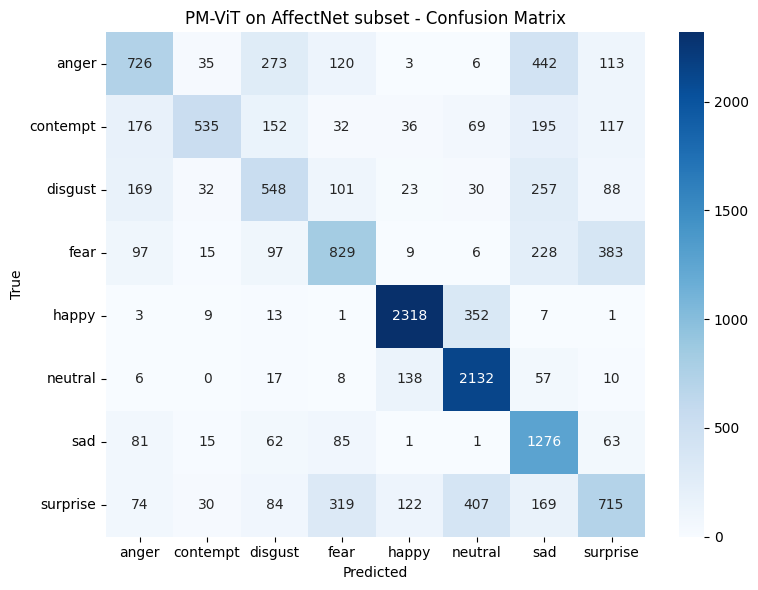

In [ ]:
target_names = full_train_dataset.classes  # <-- FIXED

print("Classification Report (PM-ViT on AffectNet subset):")
print(classification_report(test_labels, test_preds, target_names=target_names))

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PM-ViT on AffectNet subset - Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
class_names = full_train_dataset.classes
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
